# Example usage of the TaylorAnalysis with a GNN

This is an example for the usage of the TaylorAnalysis tool using an Graph Neural Network (GNN) in a graph classification task.
For this classification, we will compute TCs for the node features within the graph, edge features are also accountable, as explained below.

Base template for this NoteBook is [this](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=N-FO5xL3mw98) tutorial provided by `PyTorchGeometric`.

In [46]:
# import needed packages
import torch
import itertools

from torch.nn import Linear
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from helpers import get_feature_combis, plot_results
from tayloranalysis.model_extension import extend_model

### Dataset

The underlying dataset is published by [TUDortmund](https://chrsmrrs.github.io/datasets/).
Provided graphs are build of chemical elements forming molecule structures.
Based on these we will perform a graph classification task to infer whether a molecule is a HIV virus replicant or not.
Checkout [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) for more details.

The image below illustrates molecule structures (blue/green) which we want to separate with a GNN (orange) in an phase space (grey) of graph (molecule) properties.



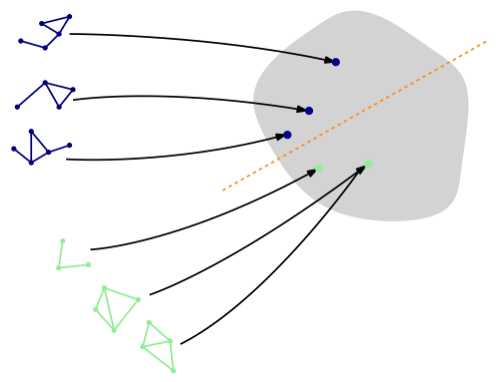

Now, let's inspect the dataset:

In [47]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Full dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print('Exemplary single datum: ', data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Node features: {data.num_node_features} (one-hot-encoding of 7 atom types)')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Full dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Exemplary single datum:  Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Node features: 7 (one-hot-encoding of 7 atom types)
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Setup the dataset:

In [48]:
train_dataset = dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Define a Graph Convolution Network (GCN) and wrap an instance with the taylor coefficient functionality:

In [49]:

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        #torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin1(x)
        x = self.lin2(x)
        
        return x

# wrap the class
WrappedGCN = extend_model(GCN)

# Intialize the model with TC functionality
model = WrappedGCN(hidden_channels=12)

Setup an optimizer and Cross Entropy loss for the training.

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

Equivalent to the DNN case: 
We have to specify for which node combinations we want to compute the TC combinations. 
For this, `itertools` provides useful functions.

In [51]:
combinations = [(i,) for i in range(7) ]  # 1st order taylor coefficients
combinations += [
    i for i in itertools.permutations(list(range(7)), 2)
]  # 2nd order taylor coefficients
combinations += [(0, 1, 1)]  # exemplary 3rd order taylor coefficient

To summarize the TCs, we have to define a reduce function. 
Other reduce functions might be: the `mode`, `min`, `max`, `nth-quantile`, ...

In [52]:
def reduce(x: torch.Tensor):
    return torch.mean(x).cpu().detach().numpy()

Remember the arguments to compute the TCs with `model.get_tc()`:
```
Args:
forward_kwargs_tctensor_key (str): Key to input tensor in forward_kwargs. Based on this tensor the taylorcoefficients are computed.
forward_kwargs (Union[None, Dict[str, Any]]): Dictionary with forward arguments
tc_idx_list (List[Tuple[int, ...]]): List of indices for which the taylorcoefficients should be computed based on the tensor selected by forward_kwargs_tctensor_key (and additional_idx_to_tctensor).
selected_output_node (Int, optional): Node selection for evaluation. Defaults to None.
eval_max_output_node_only (Bool, optional): If True, only the node with the highest value is selected. Defaults to True.
reduce_func (Callable, optional): Function to reduce the taylorcoefficients. Defaults to identity.
tctensor_features_axis (int, optional): Dimension containing features in tctensor given in forward_kwargs. Defaults to -1.
additional_idx_to_tctensor (int, optional): Index of the tctensor if forward_kwargs[forward_kwargs_tctensor_key] is a list. Defaults to None.
selected_model_output_idx (int, optional): Index of the model output if its output is a sequence. Defaults to 0.
use_parallelization (int, optional): Number of processes to use for parallelization. If None, no multiprocessing is used at all. Defaults to None.
Raises:
ValueError: tc_idx_list must be a List of tuples!

Returns:
Dict: Dictionary with taylorcoefficients. Values are set by the user within the reduce function. Keys are the indices (tuple).
```



Now everything is set up to start the training loop. 
The training process is straight forward for PyTorch (Geometric) models.
The TCs are computed after each training epoch.
For simplicity we only use the last minibatch here, you can also use the full batch, or compute the TCs for each minibatch in the training.


In [53]:
# training

model.train()
tcs_training, losses = [], []
for epoch in range(100):
    epoch_loss = 0 
    for data in train_loader:  
        optimizer.zero_grad() 
        out = model(x = data.x, edge_index= data.edge_index, batch=data.batch)  
        loss = criterion(out, data.y)  
        loss.backward()  
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    
    # TC part
    tc_dict = model.get_tc(
        "x",
        forward_kwargs={"x": data.x, "edge_index": data.edge_index, "batch": data.batch},
        tc_idx_list=combinations,
        reduce_func=reduce)

    # here we directly unpack the dictionary values into a list
    tcs_training.append(list(tc_dict.values()))
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {epoch_loss:.4f}')
    

Epoch: 0, Loss: 0.8367
Epoch: 10, Loss: 0.8131
Epoch: 20, Loss: 0.7878
Epoch: 30, Loss: 0.7596
Epoch: 40, Loss: 0.7292
Epoch: 50, Loss: 0.6978
Epoch: 60, Loss: 0.6675
Epoch: 70, Loss: 0.6462
Epoch: 80, Loss: 0.6299
Epoch: 90, Loss: 0.6204


This example computes the TCs for the node features. 
You can do the equivalent with edge features by telling the `model.get_tc()` function to combute the TCs based on `edge_features` instead of `x`, e.g.:
```
    tc_dict = model.get_tc(
        "edge_features",
        forward_kwargs={"x": data.x, "edge_index": data.edge_index, "edge_features": data.edge_feature "batch": data.batch},
        tc_idx_list=combinations,
        reduce_func=reduce)
```
Note, that you (so far) cannot compute TCs of edge and node combinations, since you can only specify one input tensor to compute the TCs for each call.

In [54]:
names = ["Carbon", "Nitrogen", "Oxygen", "Fluorine", "Iodine", "Chlorine", "Bromine"]

labels = get_feature_combis(names, combinations)
labels = [", ".join(label) for label in labels]

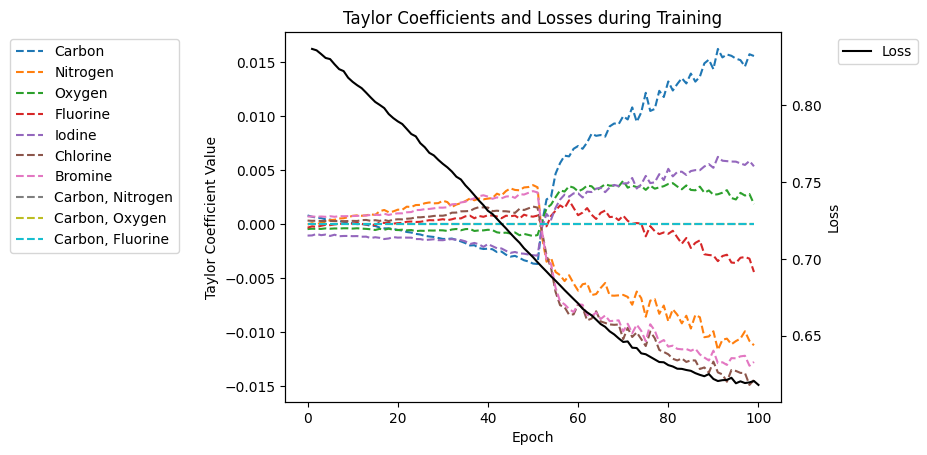

In [55]:
plot_results(losses=losses, tcs=tcs_training, tc_labels=labels, n=10)